In [1]:
# Import libraries

# System

import os

# Analysis

import numpy as np # Numerical Analysis
import laspy
import geopandas as gpd
import rasterio # Rasters
from rasterio.transform import Affine # Transformations
from rasterio import features

# Visualization

import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
# Definitions

def Save_Geotiff_to_template(array, template_path, save_path):
    '''Saves a numpy array into a geotiff with the same CRS as the template.
    '''            

    # Get metadata from template
    rst = rasterio.open(template_path) # Open template
    meta = rst.meta.copy() # Copy template metadata
    # meta.update(compress='lzw') # Good for integers/categorical rasters
    rst.close()

    with rasterio.open(save_path, 'w+', **meta) as out: # Burn features into raster
        out.write_band(1, array)
    

In [3]:
# Load plotting data

raster = np.load('template.npy')

trip = gpd.read_file('DoryTrip.geojson').to_crs('EPSG:26915')

In [4]:
# Get a list of tile_names

x_range = list(range(59,64))
y_range = list(range(28, 32))

tile_names = []

for x in x_range:
    for y in y_range:
        
        tile_name = '4342-' + str(y) + '-' + str(x) + '.las'
        
        tile_names += [tile_name]

In [5]:
# Get metadata from template
rst = rasterio.open('template.tif') # Open template
meta = rst.meta.copy() # Copy template metadata
# meta.update(compress='lzw') # Good for integers/categorical rasters
rst.close()

# Get Elevation (Aggregated in Batches)

In [6]:
# aggregate points into raster
# Takes about 15 minutes

# This version had overlap between the tiles...

for i, tile_name in enumerate(tile_names):
    
    path = os.path.join('1_raw_data', 'LasTiles', tile_name)

    las = laspy.read(path)
    
    las_geoms = gpd.points_from_xy(las.X/100, las.Y/100)
    Zs = las.Z
    
    sort_indices = np.argsort(Zs)
    
    out_fn = os.path.join('tile_elevations', tile_name[:-4] + '_elevation.tif') #os.path.join('Part_2_LasTiles', tile_name)

    with rasterio.open(out_fn, 'w+', **meta) as out: # Burn features into raster
        out_arr = out.read(1)
        

        # this is where we create a generator of geom, value pairs to use in rasterizing
        shapes = ((geom,value) for geom, value in zip(las_geoms[sort_indices], Zs[sort_indices]))

        burned = features.rasterize(shapes=shapes, 
                                    fill=0, 
                                    out=out_arr, 
                                    transform=out.transform)#,
                                    # merge_alg=rasterio.enums.MergeAlg.add) # We're not adding them, we're replacing
                                    # This is why we sorted earlier, consistently using the highest value
                                                                                  
        out.write_band(1, burned)

In [50]:
# Load those rasters!

elevs = np.empty([len(tile_names)], dtype = object) # storage for each tile

for i, tile_name in enumerate(tile_names):
    
    out_fn = os.path.join('tile_elevations', tile_name[:-4] + '_elevation.tif')
    
    rast = rasterio.open(out_fn) # Open

    elevs[i] = rast.read(1) # Save band

    rast.close() # Close

In [51]:
# Add them up to get elevation raster

full_elev = np.zeros(elevs[0].shape)

for elev in elevs:
    
    # Do any cells overlap?
    
    filled = full_elev > 1
    to_fill = elev > 1
    
    
    overlaps = np.logical_and(filled, to_fill)

    # Take average if they overlap
    
    full_elev[overlaps] = (full_elev[overlaps] + elev[overlaps])/2
    
    # Otherwise
    
    full_elev[np.invert(overlaps)] += elev[np.invert(overlaps)]

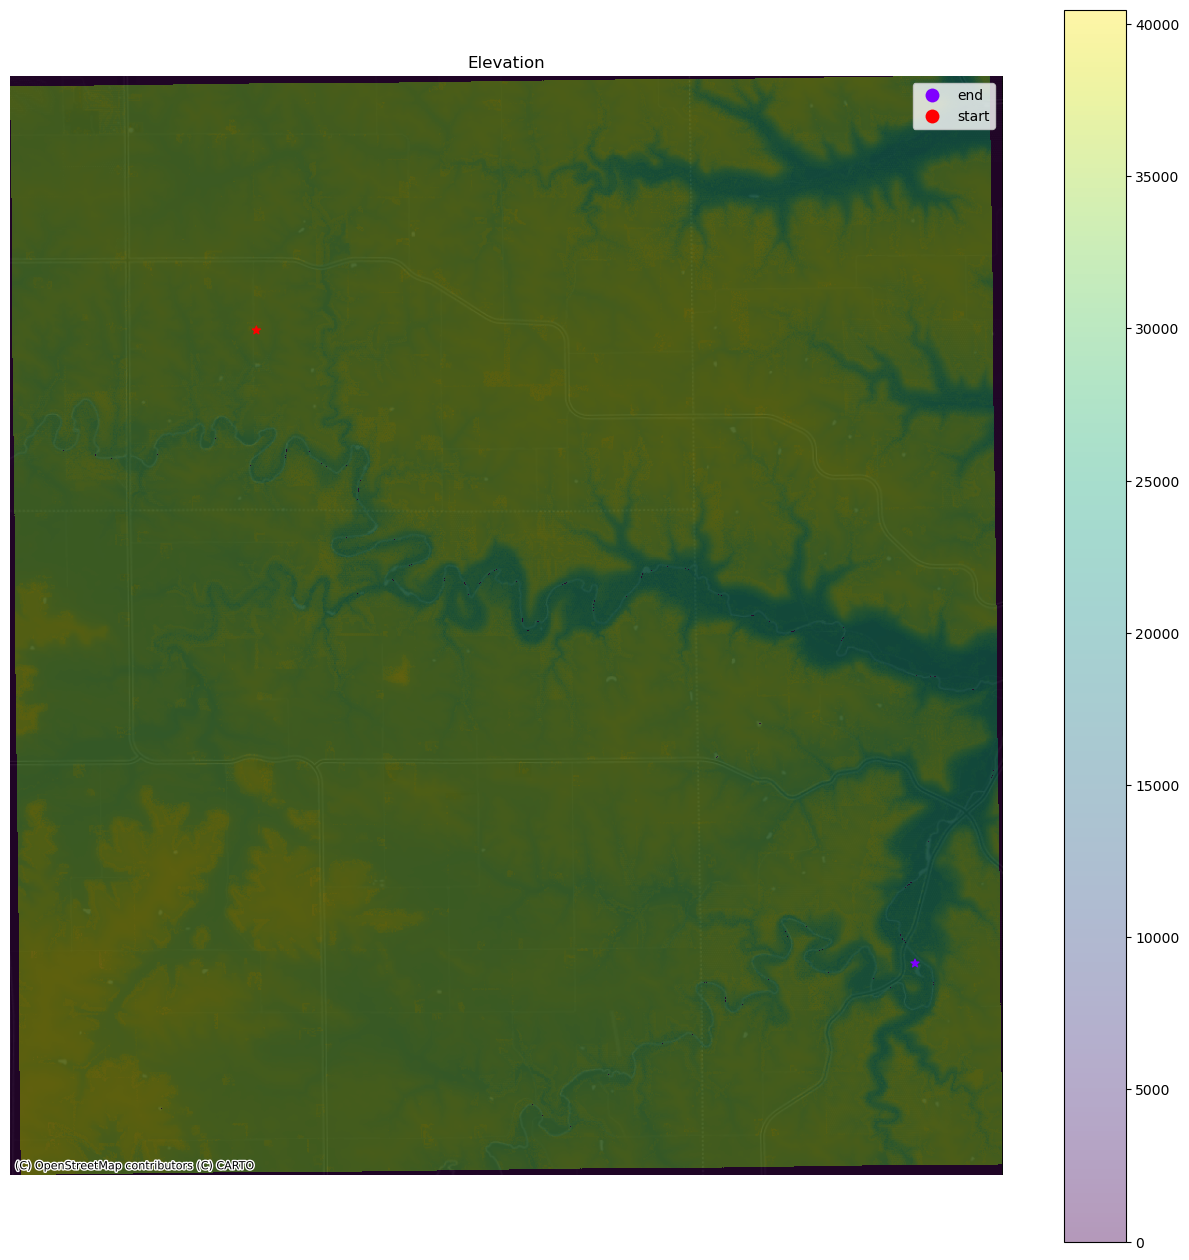

In [55]:
# PLOT!

f, ax = plt.subplots(1, figsize=(16,16)) # Initialize frame


art = ax.pcolormesh(raster[0], raster[1], full_elev.T, shading='auto', cmap = 'viridis', alpha = 0.4) # Plot interpolation

f.colorbar(art, ax = ax) # Add colorbar
title = '''Elevation'''
ax.set_title(title) # Add title
ax.set_axis_off()

trip.plot(column = 'type', cmap = 'rainbow', legend = True, marker = '*', ax = ax)

# Add basemap

ctx.add_basemap(ax = ax, 
                       crs = 'EPSG:26915', 
                       source=ctx.providers.CartoDB.DarkMatter
                      ) 

plt.show()

In [60]:
# Cool that worked

Save_Geotiff_to_template(full_elev, 'template.tif', os.path.join('3_processed_data', 'full_elevation.tif')

# Water and Brides

In [83]:
# Now to get water & bridges

# Classifications


#     2 Ground
#     5 Vegetation
#     6 – Building
#     8 – Model Keypoint (points required to maintain surface integrity).
#     9 – Water
#     10 – Breakline Proximity. Points within 3 meters of a breakline
#     12 – Overlap Points
#     14 – Bridge Decks <- There's no bridges!!!

# aggregate points into raster

for i, tile_name in enumerate(tile_names):
    
    path = os.path.join('3_processed_data','LasTiles', tile_name)

    las = laspy.read(path)
    
    las_geoms = gpd.points_from_xy(las.X/100, las.Y/100)
    
    # Is water or bridge?
    classifications = np.array(las.classification)
    
    # print(np.unique(classifications))

    water_indices = np.argwhere(classifications==9)
    bridge_indices = np.argwhere(classifications==14)
    
    water_and_bridge_indices = np.append(bridge_indices, water_indices)
    
    # Create value to burn, bridge = 1, water = -1
    
    water_bool = -np.ones(len(water_indices))
    bridge_bool = np.ones(len(bridge_indices))
    
    water_and_bridge_bool = np.append(bridge_bool, water_bool)
    
    # Rasterize
    
    if len(water_and_bridge_indices) > 0: # Sometimes there's no water/bridges
    
        out_fn = os.path.join('tile_water_and_bridges', tile_name[:-4] + '_water_and_bridges.tif') #os.path.join('Part_2_LasTiles', tile_name)

        with rasterio.open(out_fn, 'w+', **meta) as out: # Burn features into raster
            out_arr = out.read(1)


            # this is where we create a generator of geom, value pairs to use in rasterizing
            shapes = ((geom,value) for geom, value in zip(las_geoms[water_and_bridge_indices], water_and_bridge_bool))

            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform)#,
                                        # merge_alg=rasterio.enums.MergeAlg.add) # We're not adding them, we're replacing
                                        # This is why we sorted earlier, consistently using the bridge over water

            out.write_band(1, burned)  

[ 0  2  5  6  8 10 12]
[ 0  2  5  6  8  9 10 12]
[ 0  2  5  6  8  9 10 12]
[ 0  2  5  6  8  9 10 12]
[ 0  2  5  6  8  9 10 12]
[ 0  2  5  6  8  9 10 12]
[ 0  2  5  6  8  9 10 12]
[ 0  2  5  6  8 12]
[ 0  2  5  6  8  9 10 12]
[ 0  2  5  6  8  9 12]
[ 0  2  5  6  8  9 10 12]
[ 0  2  5  6  8  9 10 12]
[ 0  2  5  6  8  9 12]
[ 0  2  5  6  8  9 10 12]
[ 0  2  5  6  8  9 12]
[ 0  2  5  6  8  9 12]
[ 0  2  5  6  8  9 12]
[ 0  2  5  6  8  9 12]
[ 0  2  5  6  8  9 10 12]
[ 0  2  5  6  8  9 10 12]


In [ ]:
# Wow, there's no bridges... Hmmmm

In [104]:
# Load those rasters!

waters = np.empty([len(tile_names)], dtype = object) # storage for each tile

for i, tile_name in enumerate(tile_names):
    
    out_fn = os.path.join('tile_water_and_bridges', tile_name[:-4] + '_water_and_bridges.tif')
    
    if os.path.exists(out_fn):
    
        rast = rasterio.open(out_fn) # Open

        waters[i] = rast.read(1) # Save band

        rast.close() # Close
    else:
        waters[i] = np.zeros(full_elev.shape)

In [105]:
# Merge

full_water = np.zeros(full_elev.shape)


for water in waters:
    
    # Do any cells overlap?
    
    filled = full_water != 0
    to_fill = water != 0
    
    
    overlaps = np.logical_and(filled, to_fill)

    # Take average if they overlap
    
    full_water[overlaps] = (full_water[overlaps] + water[overlaps])/2
    
    # Otherwise
    
    full_water[np.invert(overlaps)] += water[np.invert(overlaps)]

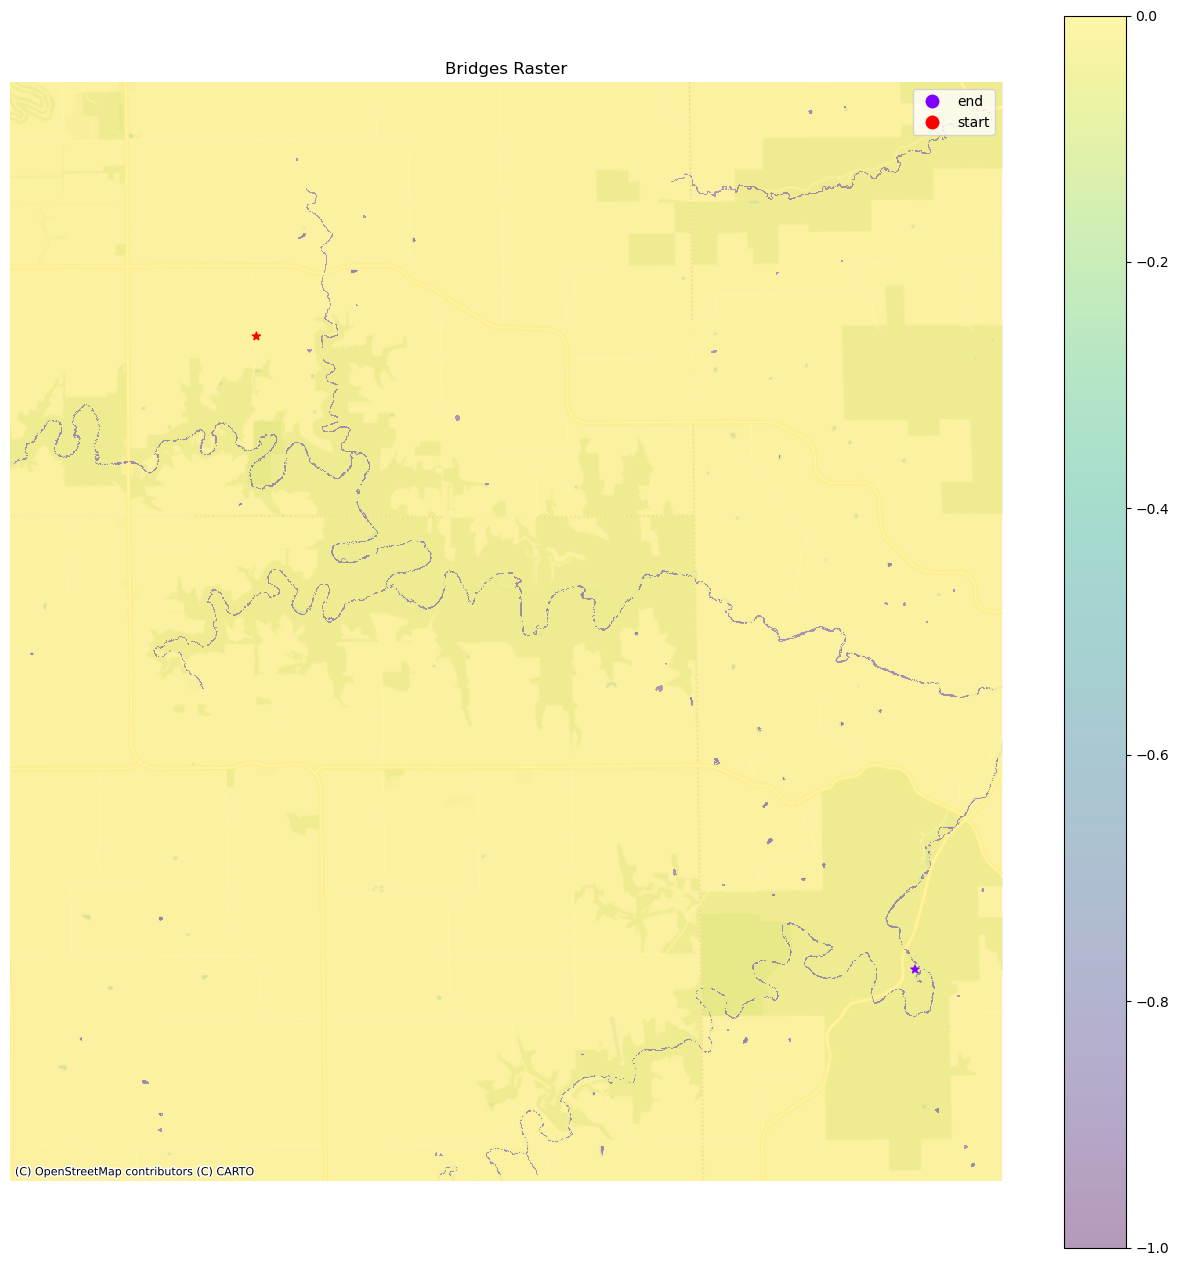

In [106]:
# PLOT!

f, ax = plt.subplots(1, figsize=(16,16)) # Initialize frame


art = ax.pcolormesh(raster[0], raster[1], full_water.T, shading='auto', cmap = 'viridis', alpha = 0.4) # Plot interpolation

f.colorbar(art, ax = ax) # Add colorbar
title = '''Bridges Raster'''
ax.set_title(title) # Add title
ax.set_axis_off()

trip.plot(column = 'type', cmap = 'rainbow', legend = True, marker = '*', ax = ax)

# Add basemap

ctx.add_basemap(ax = ax, 
                       crs = 'EPSG:26915', 
                       source=ctx.providers.CartoDB.Voyager
                      ) 

plt.show()

In [101]:
# Looks okay

Save_Geotiff_to_template(full_water, 'template.tif', os.path.join('3_processed_data', 'full_water.tif')

# Getting Bridges

Went to geojson.io and found them. Marked as points

In [94]:
bridges = gpd.read_file(os.path.join('1_raw_data','bridges.geojson').to_crs('EPSG:26915')

In [97]:
# Find the nearest cells to the bridges

# Get filenames
out_fn = os.path.join('3_processed_data','rasterized_bridges.tif')

with rasterio.open(out_fn, 'w+', **meta) as out: # Burn features into template raster
    out_arr = out.read(1)
    
    is_bridge = np.ones(len(bridges))

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(bridges.geometry, is_bridge))

    burned = features.rasterize(shapes=shapes, 
                                fill=0, 
                                out=out_arr, 
                                transform=out.transform)
                                # merge_alg=rasterio.enums.MergeAlg.add) 
    out.write_band(1, burned)

In [98]:
# Load that raster

rast = rasterio.open(out_fn) # Open

bridges_rast = rast.read(1) # Save band

rast.close() # Close

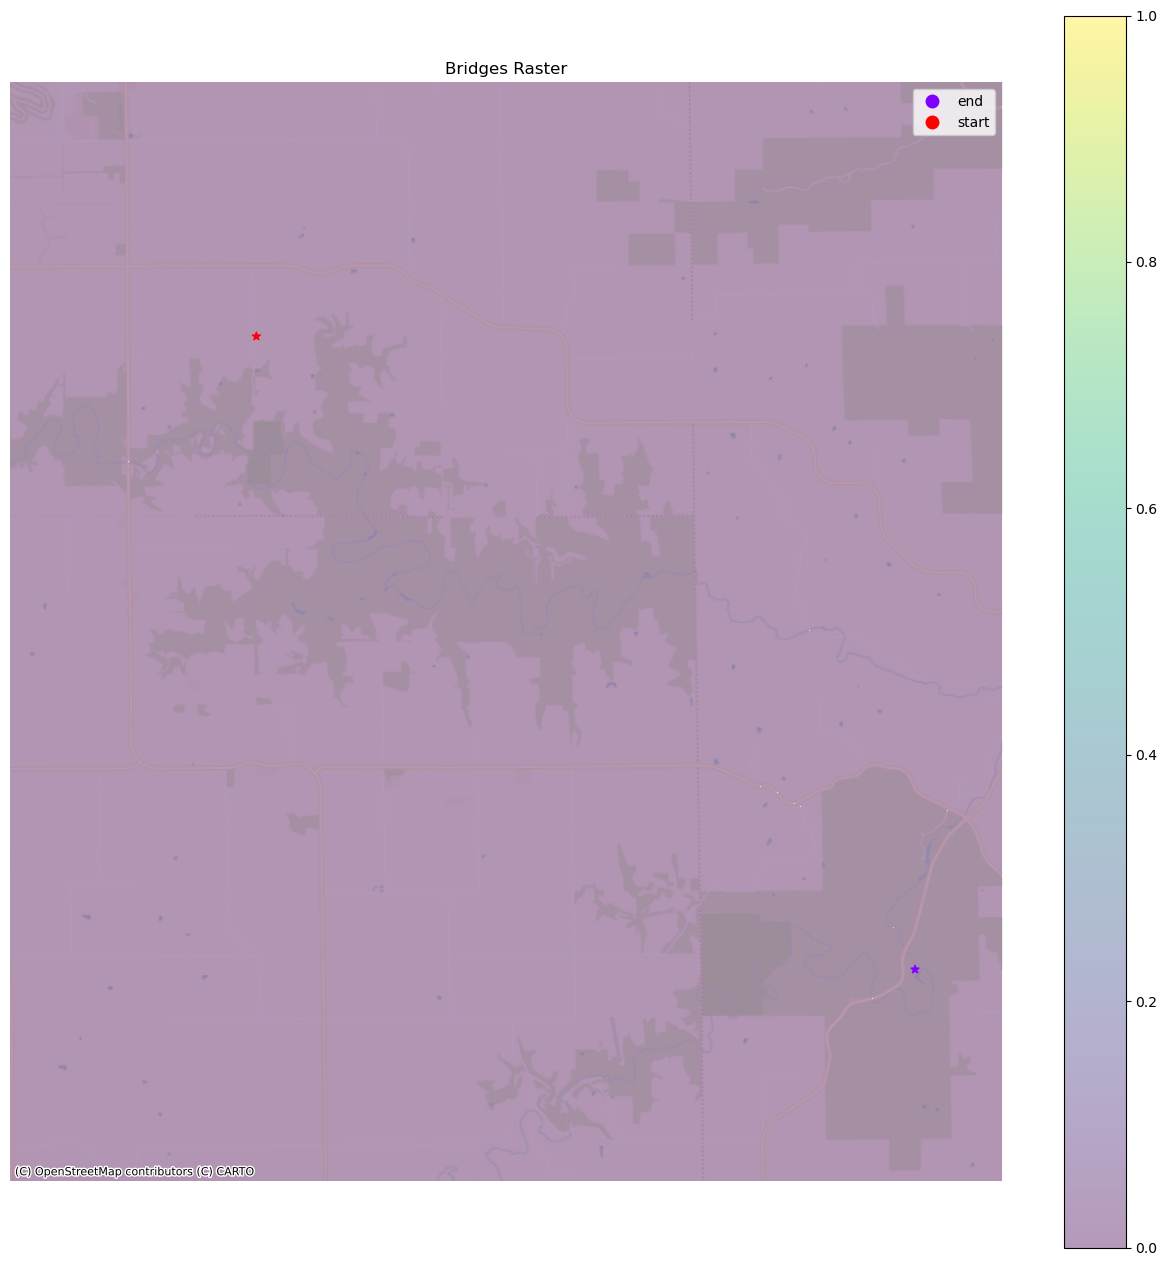

In [100]:
# PLOT!

f, ax = plt.subplots(1, figsize=(16,16)) # Initialize frame


art = ax.pcolormesh(raster[0], raster[1], bridges_rast.T, shading='auto', cmap = 'viridis', alpha = 0.4) # Plot interpolation

f.colorbar(art, ax = ax) # Add colorbar
title = '''Bridges Raster'''
ax.set_title(title) # Add title
ax.set_axis_off()

trip.plot(column = 'type', cmap = 'rainbow', legend = True, marker = '*', ax = ax)

# Add basemap

ctx.add_basemap(ax = ax, 
                       crs = 'EPSG:26915', 
                       source=ctx.providers.CartoDB.Voyager
                      ) 

plt.show()

In [101]:
# Looks okay

In [113]:
# Now combine with water

water_and_bridges = full_water + bridges_rast

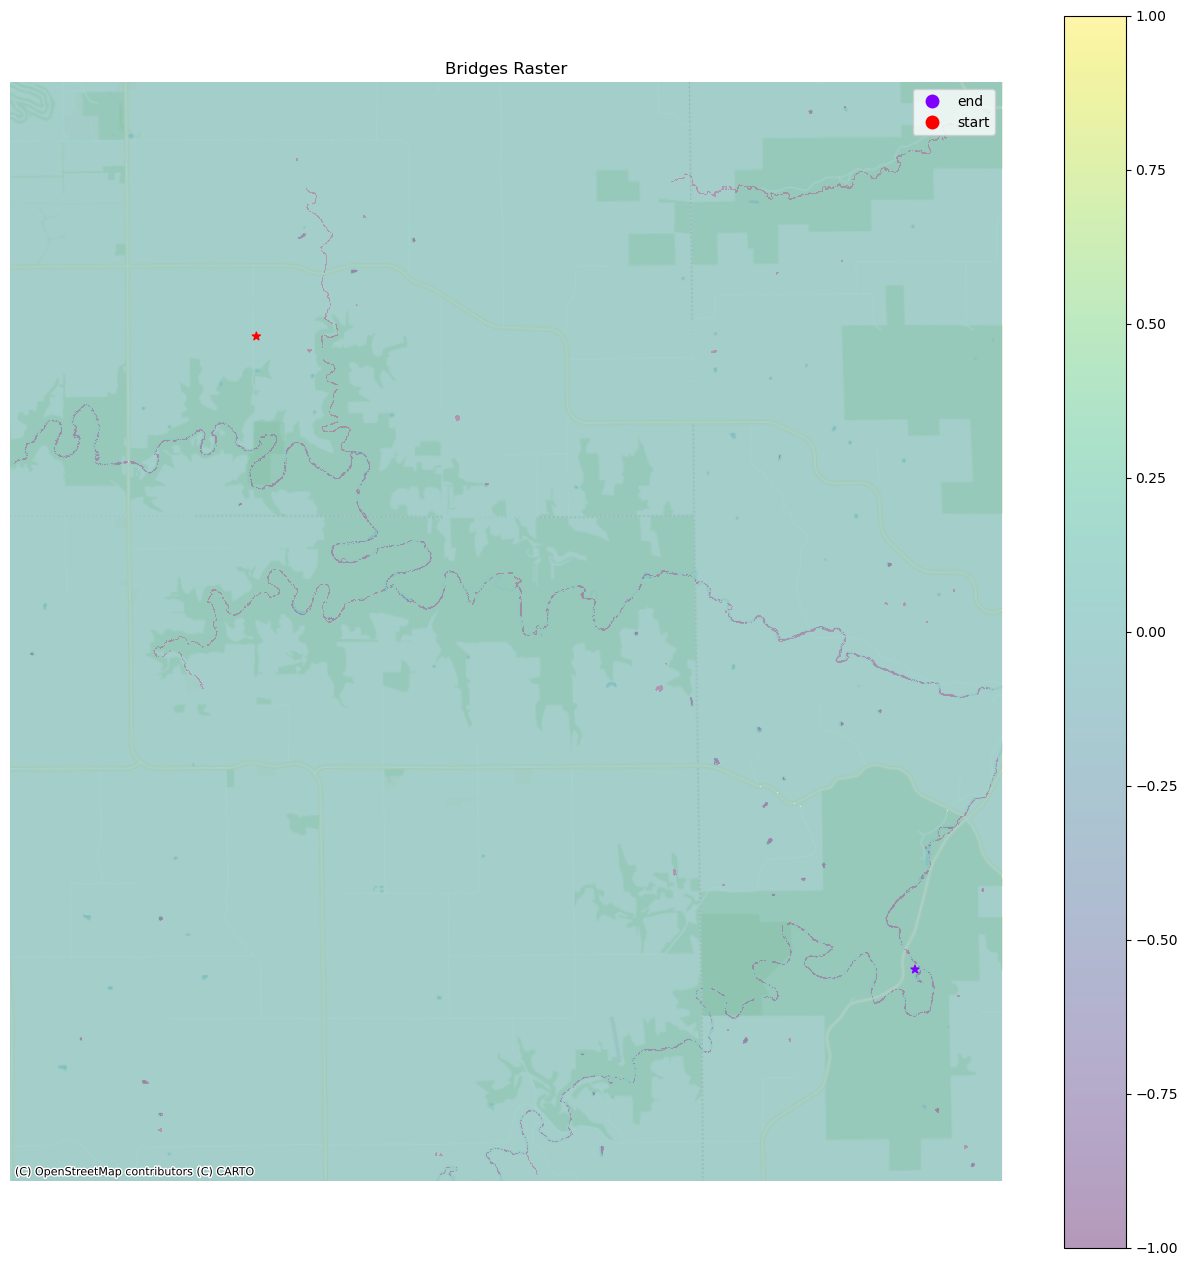

In [114]:
# PLOT!

f, ax = plt.subplots(1, figsize=(16,16)) # Initialize frame


art = ax.pcolormesh(raster[0], raster[1], water_and_bridges.T, shading='auto', cmap = 'viridis', alpha = 0.4) # Plot interpolation

f.colorbar(art, ax = ax) # Add colorbar
title = '''Bridges Raster'''
ax.set_title(title) # Add title
ax.set_axis_off()

trip.plot(column = 'type', cmap = 'rainbow', legend = True, marker = '*', ax = ax)

# Add basemap

ctx.add_basemap(ax = ax, 
                       crs = 'EPSG:26915', 
                       source=ctx.providers.CartoDB.Voyager
                      ) 

plt.show()

In [115]:
# Well, that isn't exactly right but we'll try it?

Save_Geotiff_to_template(water_and_bridges, 'template.tif', os.path.join('3_processed_data','full_water_and_bridges.tif'))

# Rasterize Fields

In [108]:
fields = gpd.read_file('1_raw_data', 'fields.geojson')

In [109]:
# Find the nearest cells to the bridges

# Get filenames
out_fn = 'rasterized_fields.tif'

with rasterio.open(out_fn, 'w+', **meta) as out: # Burn features into template raster
    out_arr = out.read(1)
    
    is_field = np.ones(len(fields))

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(fields.geometry, is_field))

    burned = features.rasterize(shapes=shapes, 
                                fill=0, 
                                out=out_arr, 
                                transform=out.transform)
                                # merge_alg=rasterio.enums.MergeAlg.add) 
    out.write_band(1, burned)

In [110]:
# Load that raster

rast = rasterio.open(out_fn) # Open

field_rast = rast.read(1) # Save band

rast.close() # Close

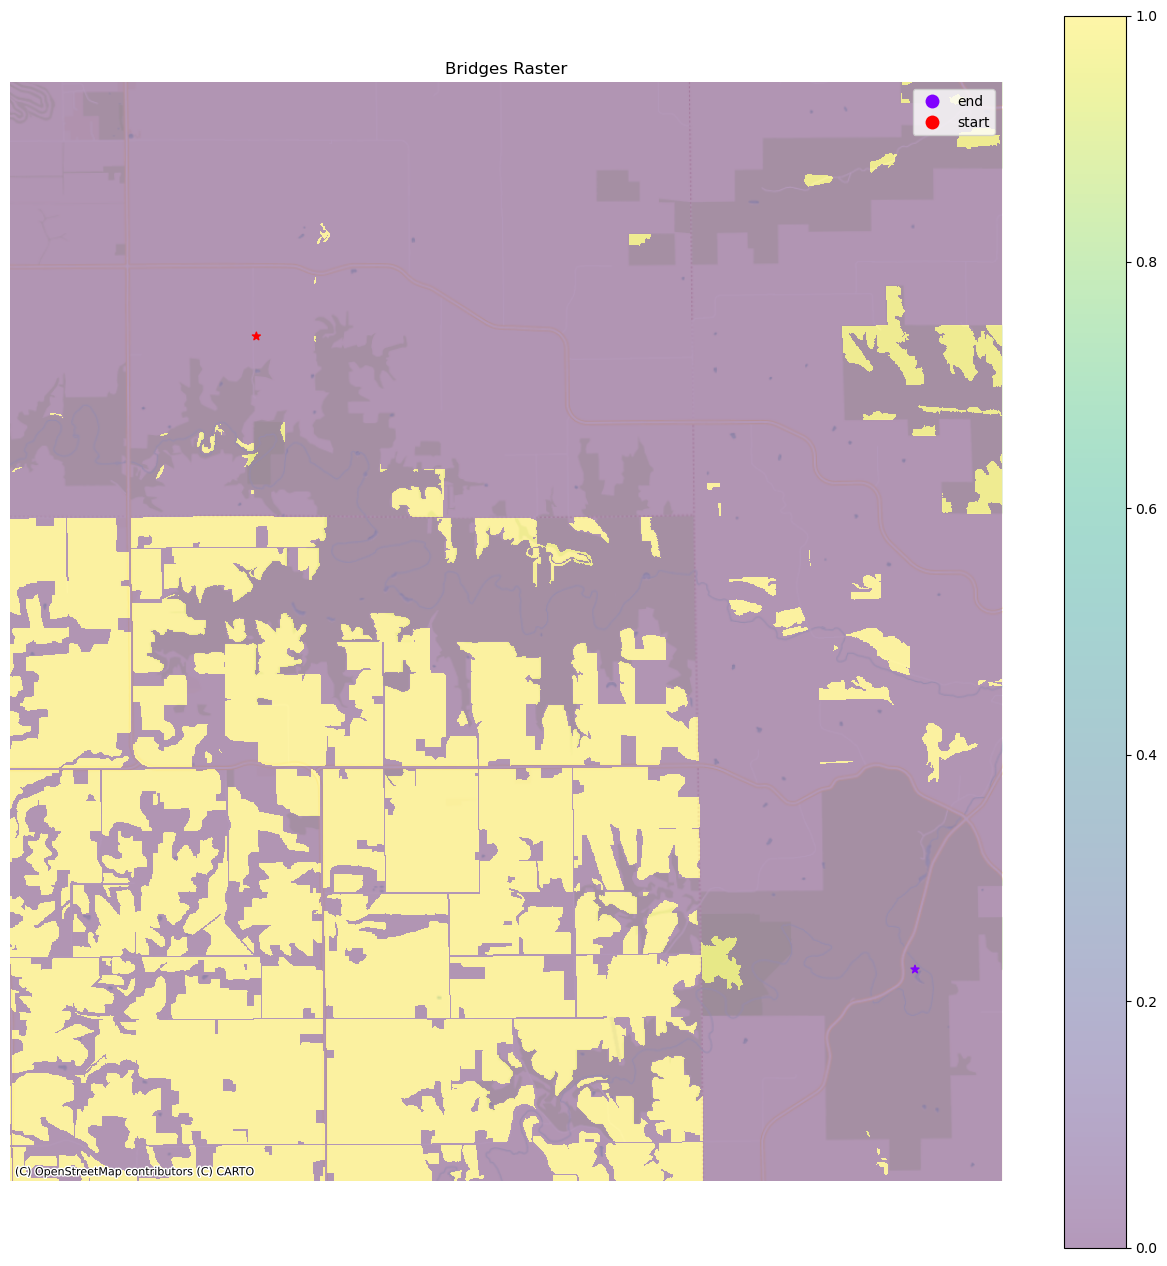

In [111]:
# PLOT!

f, ax = plt.subplots(1, figsize=(16,16)) # Initialize frame


art = ax.pcolormesh(raster[0], raster[1], field_rast.T, shading='auto', cmap = 'viridis', alpha = 0.4) # Plot interpolation

f.colorbar(art, ax = ax) # Add colorbar
title = '''Fields Raster'''
ax.set_title(title) # Add title
ax.set_axis_off()

trip.plot(column = 'type', cmap = 'rainbow', legend = True, marker = '*', ax = ax)

# Add basemap

ctx.add_basemap(ax = ax, 
                       crs = 'EPSG:26915', 
                       source=ctx.providers.CartoDB.Voyager
                      ) 

plt.show()

## If ArcPy is Needed

In [8]:
# # Convert Las to Raster?

# tile_indices = [x[1] for x in tile_info]

# rasterized = True

# if not(rasterized):

#     for tile_index in tile_indices:

#         las_name = tile_index + '.las'
#         path = os.path.join('Part_2_LasTiles', las_name)

#         # savepath = 


#         arcpy.conversion.LasDatasetToRaster(path, r"c:\users\hendr862\desktop\arc1\arc1_lab02_part2\arc1_lab02_part2.gdb\c43583_lasda",
#                                         "ELEVATION", "BINNING AVERAGE LINEAR", "FLOAT", "CELLSIZE", 1, 1)